# Model Training

In [17]:
%load_ext autoreload
%autoreload 2

import common
import pandas as pd
import scipy.sparse
import joblib
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import wandb
import pickle
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
wandb.login()

True

In [19]:
def evaluate(y_true,y_pred,digits=5):
    print(classification_report(y_true,y_pred,digits=digits))
    confusion_mtx = confusion_matrix(y_true,y_pred)
    disp = ConfusionMatrixDisplay(confusion_mtx)
    disp.plot()
    plt.show()

## Parameters

In [20]:
# change this accordingly
project_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

save_path = f"{project_path}/scicite_preprocessed"
dataset = "selected-features"
project_name = "model-comparison-smote-log-reg-fine-tuned"

## 1. Load dataset

In [21]:
train_df = pd.read_csv(f"{save_path}/train-{dataset}.csv")
test_df = pd.read_csv(f"{save_path}/test-{dataset}.csv")
label_encoder = joblib.load(f"{save_path}/label_encoder.pkl")

X_train = train_df.drop(columns=['label'])
y_train = train_df["label"]
X_test = test_df.drop(columns=['label'])
y_test = test_df["label"]

smote = SMOTE(sampling_strategy='all', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## 2. Train-validation split

In [22]:
# Split into 80% train and 20% validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Train logistic regression classifier

e:\cs4248_proj\nlp_proj\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Classifier based line
-----Evaluation-----
Accuracy: 0.7643
Macro F1-score: 0.7398
Micro F1-score: 0.7643


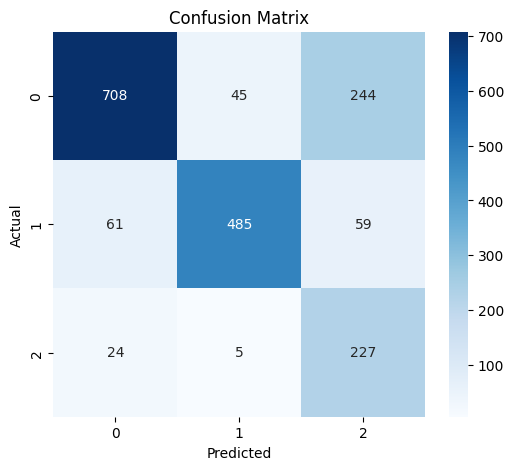

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy Score,▁
Macro F1-score,▁
Micro F1-score,▁
Accuracy Score,0.76426
Macro F1-score,0.73985
Micro F1-score,0.76426


In [23]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

wandb.init(entity='cs4248-nlp-project',project=f"{project_name}-{dataset}", name="log-reg-base-line")
common.evaluate(y_test, y_pred, label_encoder, "Logistic Regression Classifier based line")
wandb.finish()

## Fine tuned logistic regression Classifier

In [24]:
params = {"C":[0.01, 0.1, 1, 10, 100],"max_iter":[10000000],'class_weight':['balanced',None]}

In [ ]:
model = LogisticRegression()
model = GridSearchCV(model,params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test,y_pred)
wandb.init(entity='cs4248-nlp-project',project=f"{project_name}-{dataset}", name="log-reg-fine-tuned")
common.evaluate(y_test, y_pred, label_encoder, "Logistic Regrssion Classifier fine tuned")
wandb.finish()
with open(r"E:\cs4248_proj\CS4248-NLP-Project\model\fine-tuned-log-reg.pkl", "wb") as f:
    pickle.dump(model)


In [ ]:
model.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'n_estimators': 1000,
 'n_jobs': -1}

In [ ]:
model.cv_results_

{'mean_fit_time': array([ 3.74838028, 37.11943932, 45.55374932,  3.1403358 , 10.80148039,
        31.45782409]),
 'std_fit_time': array([ 0.35533615, 31.45119191, 43.03028302,  0.09663012,  0.53205689,
        22.26314881]),
 'mean_score_time': array([0.27358451, 1.09865165, 0.98737245, 0.29785457, 0.49144115,
        1.10685277]),
 'std_score_time': array([0.02941891, 0.58692793, 0.32158568, 0.08811357, 0.06089442,
        0.5647314 ]),
 'param_class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                    'balanced', 'balanced'],
              mask=[False, False, False, False, False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'entropy', 'entropy',
                    'entropy'],
              mask=[False, False, False, False, False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 500, 1000, 